<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Short Sale Availability

This notebook explores the percentage of listings that are shortable by country, above a given dollar volume threshold.

In [1]:
from quantrocket import get_prices
from quantrocket.fundamental import download_shortable_shares, NoFundamentalData
from quantrocket.account import download_exchange_rates
import pandas as pd
import io

Get exchange rates (for converting non-USD stocks to USD dollar volume):

In [2]:
f = io.StringIO()
download_exchange_rates(f, latest=True, base_currencies="USD")
rates = pd.read_csv(f)
rates = rates.set_index("QuoteCurrency").Rate.to_dict()

In [3]:
def get_conids(db, start_date, min_dollar_volume=0, max_dollar_volume=None, universes=None):
    """
    Return the list of conids for the db, optionally with average dollar volume above or below the threshold(s).
    """

    prices = get_prices(
        db, 
        start_date=start_date, 
        universes=universes, 
        fields=["Close","Volume"], 
        master_fields=["Currency","Multiplier","PriceMagnifier"])
        
    closes = prices.loc["Close"]
    volumes = prices.loc["Volume"]
    currencies = prices.loc["Currency"]
    multipliers = prices.loc["Multiplier"].reindex(closes.index, method="ffill")
    magnifiers = prices.loc["PriceMagnifier"].reindex(closes.index, method="ffill")
    exchange_rates = currencies.applymap(lambda x: rates[x])
    exchange_rates = exchange_rates.reindex(closes.index, method="ffill")
    closes = closes * multipliers.fillna(1) / magnifiers.fillna(1)
    dollar_volumes = closes.div(exchange_rates) * volumes
    avg_dollar_volumes = dollar_volumes.mean()
    
    if min_dollar_volume:
        avg_dollar_volumes = avg_dollar_volumes[avg_dollar_volumes >= min_dollar_volume]
    if max_dollar_volume:
        avg_dollar_volumes = avg_dollar_volumes[avg_dollar_volumes <= max_dollar_volume]
    
    conids = list(avg_dollar_volumes.index)

    return conids

In [4]:
def get_shortable_universe_size(conids, start_date):
    """
    Queries shortable shares and counts the unique conids.
    """
    f = io.StringIO()
    try:
        download_shortable_shares(f, conids=conids, start_date=start_date)
    except NoFundamentalData:
        return 0
    else:
        return len(pd.read_csv(f).ConId.unique())

In [5]:
def get_shortable_ratio(db, min_dollar_volume=None, max_dollar_volume=None):
    """
    Divides count of shortable conids by total conids in the last 90 days.
    """
    start_date = pd.Timestamp.today() - pd.Timedelta('90D')
    start_date = start_date.date().isoformat()
    conids = get_conids(db, start_date, min_dollar_volume=min_dollar_volume, max_dollar_volume=max_dollar_volume)
    shortable_size = get_shortable_universe_size(conids, start_date)
    return (shortable_size/len(conids)) * 100  

Countries for which numbers should be run:

In [6]:
countries = (
    # North America
    ("usa-stk-1d", "United States"),
    ("canada-stk-1d", "Canada"),
    ("mexico-stk-1d", "Mexico"),
    
    # Asia
    ("australia-stk-1d", "Australia"),
    ("japan-stk-1d", "Japan"),
    ("hongkong-stk-1d", "Hong Kong"),
    ("singapore-stk-1d", "Singapore"),
    
    # Europe
    ("spain-stk-1d", "Spain"),
    ("netherlands-stk-1d", "Netherlands"),
    ("uk-stk-1d", "United Kingdom"),
    ("germany-stk-1d", "Germany"),
    ("france-stk-1d", "France"),
    ("belgium-stk-1d", "Belgium"),
    ("swiss-stk-1d", "Switzerland"),
    ("austria-stk-1d", "Austria"),
    ("sweden-stk-1d", "Sweden"),
    ("italy-stk-1d", "Italy"),
)

Run numbers for each country, first with no dollar volume filter:

In [7]:
all_countries = {}

for db, country in countries:
    print(country)
    all_countries[country] = get_shortable_ratio(db, min_dollar_volume=0)
    
shortable_ratios = pd.Series(all_countries, name="shortable").to_frame()
shortable_ratios["not shortable"] = 100 - shortable_ratios

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette=sns.color_palette("Reds_r", n_colors=2))

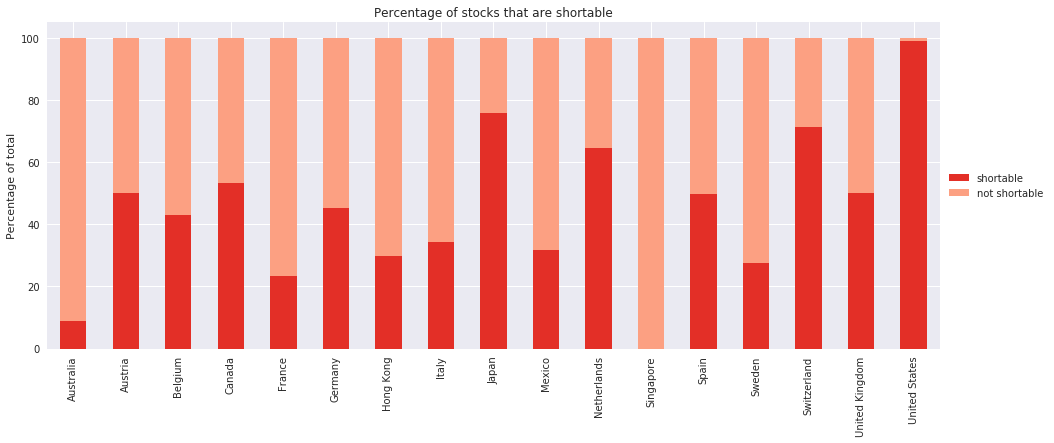

In [9]:
ax = shortable_ratios.sort_index().plot(kind="bar", stacked=True, title="Percentage of stocks that are shortable", figsize=(16,6))
ax.set_ylabel("Percentage of total")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Repeat with a dollar volume threshold of $1M USD.

In [10]:
all_countries = {}

for db, country in countries:
    print(country)
    all_countries[country] = get_shortable_ratio(db, min_dollar_volume=1000000)
    
shortable_ratios = pd.Series(all_countries, name="shortable").to_frame()
shortable_ratios["not shortable"] = 100 - shortable_ratios

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


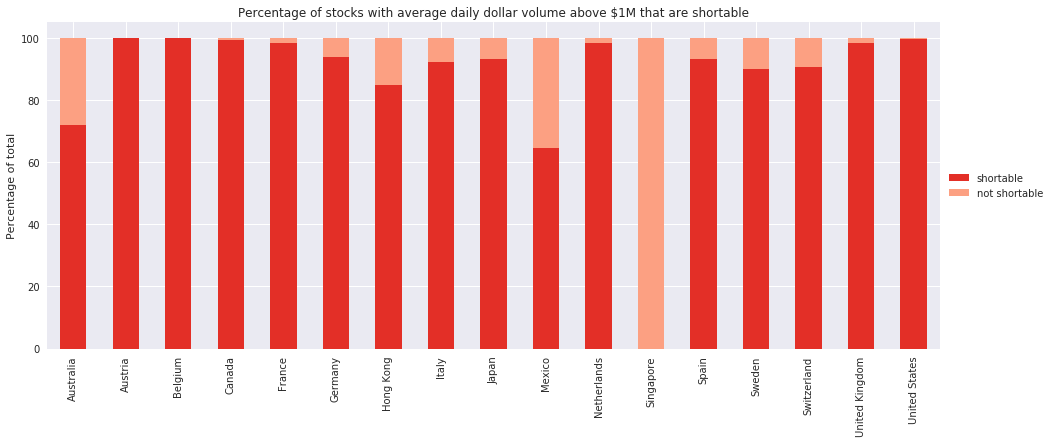

In [11]:
ax = shortable_ratios.sort_index().plot(kind="bar", stacked=True, title="Percentage of stocks with average daily dollar volume above $1M that are shortable", figsize=(16,6))
ax.set_ylabel("Percentage of total")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Limit to stocks below $1M USD dollar volume:

In [8]:
all_countries = {}

for db, country in countries:
    print(country)
    all_countries[country] = get_shortable_ratio(db, max_dollar_volume=1000000)
    
shortable_ratios = pd.Series(all_countries, name="shortable").to_frame()
shortable_ratios["not shortable"] = 100 - shortable_ratios

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


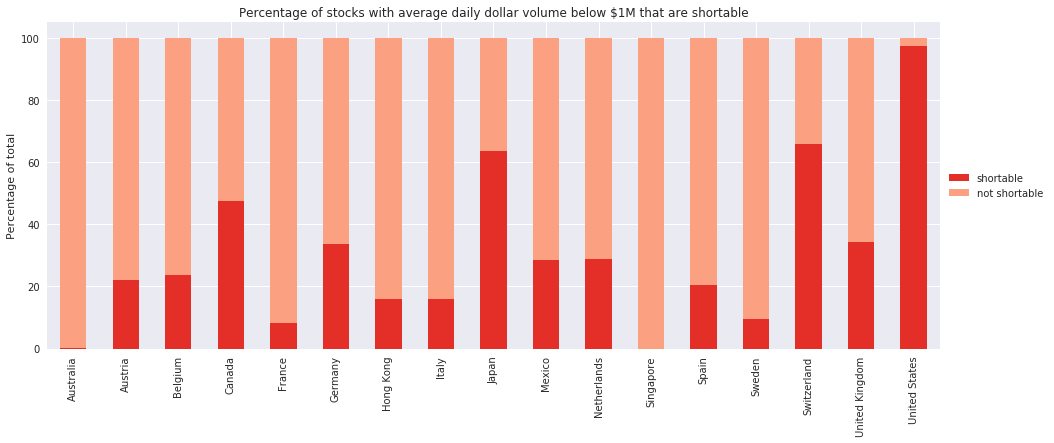

In [9]:
ax = shortable_ratios.sort_index().plot(kind="bar", stacked=True, title="Percentage of stocks with average daily dollar volume below $1M that are shortable", figsize=(16,6))
ax.set_ylabel("Percentage of total")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

***

[Back to Introduction](Introduction.ipynb)